# import and set up

In [13]:
import warnings
warnings.filterwarnings('ignore')
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
sys.path.append('./../src/')
import dill
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import utils
from utils import id_to_name, name_to_id
import pickle
import random
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(9)
np.random.seed(9)

with open('./../annotation/ontologies.dill', 'rb') as f:
    full_ontology, training_ontology = dill.load(f)

mlb=utils.mlb

Mv, meta = dill.load(open(f'./../data/GEO/preprocessed/training.dill', 'rb'))

meta_multi = utils.propagate_parent(training_ontology, meta, tissue_col='training.ID', outdict=False)
meta_mlb = mlb.transform(meta_multi['training.ID'].values)

Propagating with training.ID


In [2]:
print(Mv.shape, meta.shape)

(10351, 297598) (10351, 10)


In [3]:
print(meta['training.ID'].nunique())
print(meta['Dataset'].nunique())

55
210


In [9]:
# Load custom id_to_color
df = pd.read_csv('./../annotation/id_display_mappings.txt', sep='\t')
id_to_color = pd.Series(df.color.values, index=df.ID).to_dict()

In [ ]:
# System-based ordered descendants set
descendants_set = []
system_to_children = dict()
seen = set()
for x in training_ontology.successors('root'):
    descendants_set.append(x)
    seen.add(x)
    system_to_children[x] = list(nx.descendants(training_ontology, x)) + [x]
    for descendant in nx.descendants(training_ontology, x):
        if descendant not in seen:
            descendants_set.append(descendant)
            seen.add(descendant)

print(descendants_set)

['UBERON:0002204', 'UBERON:0002371', 'UBERON:0002418', 'CL:0000056', 'UBERON:0002481', 'UBERON:0004535', 'UBERON:8450002', 'UBERON:0002113', 'UBERON:0000483', 'UBERON:0001043', 'UBERON:0004802', 'UBERON:0005384', 'UBERON:0002424', 'UBERON:0001004', 'UBERON:0002048', 'UBERON:0001005', 'UBERON:0002050', 'UBERON:0002331', 'UBERON:0001987', 'UBERON:0012168', 'CL:0002322;BTO:0001086', 'UBERON:0002390', 'CL:0000910;BTO:0000289', 'CL:0000775', 'CL:2000001', 'CL:0000576', 'CL:0000542', 'CL:0000738', 'CL:0000084', 'CL:0000236', 'CL:0000094', 'CL:0000623', 'UBERON:0000178', 'UBERON:0000990', 'UBERON:0002367', 'UBERON:0000002', 'UBERON:0003134', 'UBERON:0001295', 'CL:0000019', 'UBERON:0000992', 'UBERON:0003889', 'UBERON:0000079', 'UBERON:0001032', 'UBERON:0000949', 'UBERON:0000006', 'UBERON:0001264', 'UBERON:0002107', 'UBERON:0002046', 'UBERON:0002330', 'UBERON:0000310', 'UBERON:0001836', 'UBERON:0001016', 'UBERON:0002037', 'UBERON:0001870', 'UBERON:0000955', 'UBERON:0000956', 'UBERON:0001871', '

In [6]:
# Load minipatch selector and grab minipatch probes
filename = f"_whole"
minipatch_location = f"./../data/GEO/minipatch/minipatch{filename}_selector"
print(f"loading minipatch selector from {minipatch_location}")
fitted_selector = dill.load(open(minipatch_location, 'rb'))

selection_frequency_threshold = 0.65
selection_freq = pd.DataFrame(fitted_selector.Pi_hat_last_k_, index=Mv.columns)
minipatch_probes = list(selection_freq[selection_freq[0]>=selection_frequency_threshold].index)
Mv_minipatch = Mv45 = Mv[minipatch_probes]
print(Mv_minipatch.shape)

loading minipatch selector from ./../data/GEO/minipatch/minipatch_whole_selector
(10351, 190)


# Figure 1

## M-value profiles

## Training ontology

In [10]:
from networkx.drawing.nx_agraph import graphviz_layout

In [19]:
def display_id_graph_pretty(G, node_cols=None, figsize=(35, 10), save='', id_to_name=None):
        
    plt.figure(figsize=figsize)
    plt.axis('off')
    pos = graphviz_layout(G, prog='dot', root="root")
    
    # Use id_to_name dictionary for display purposes if provided
    if id_to_name:
        labels = {node: '\n'.join(id_to_name.get(node, [node])).replace(' ', '\n') if node != "root" else "" for node in G.nodes()}
    else:
        labels = {node: node.replace(' ', '\n') if node != "root" else "" for node in G.nodes()}

    node_colors = []
    if node_cols is not None:
        for node in G.nodes():
            if node == 'root':
                node_colors.append('grey')
            elif node in node_cols:
                node_colors.append(node_cols[node])
            else:
                node_colors.append('lightblue')
    else:
        for node in G.nodes():
            node_colors = 'lightblue'
    
    nx.draw_networkx_edges(G, pos, arrowsize=3, edge_color="#A9A9A9", alpha=0.35)
    nx.draw_networkx_nodes(G,pos,node_color=node_colors, node_size=60, linewidths=None)
    
    # hack for moving labels away from nodes
    pos_off = {}
    y_off = -10  # offset on the y axis
    for k, v in pos.items():
        pos_off[k] = (v[0], v[1]+y_off)
    nx.draw_networkx_labels(G, pos_off, labels, font_size=6,verticalalignment="top")
            
    if len(save) > 1:
        plt.savefig('./../figures/' + save + '.pdf', dpi=300)
    plt.show()

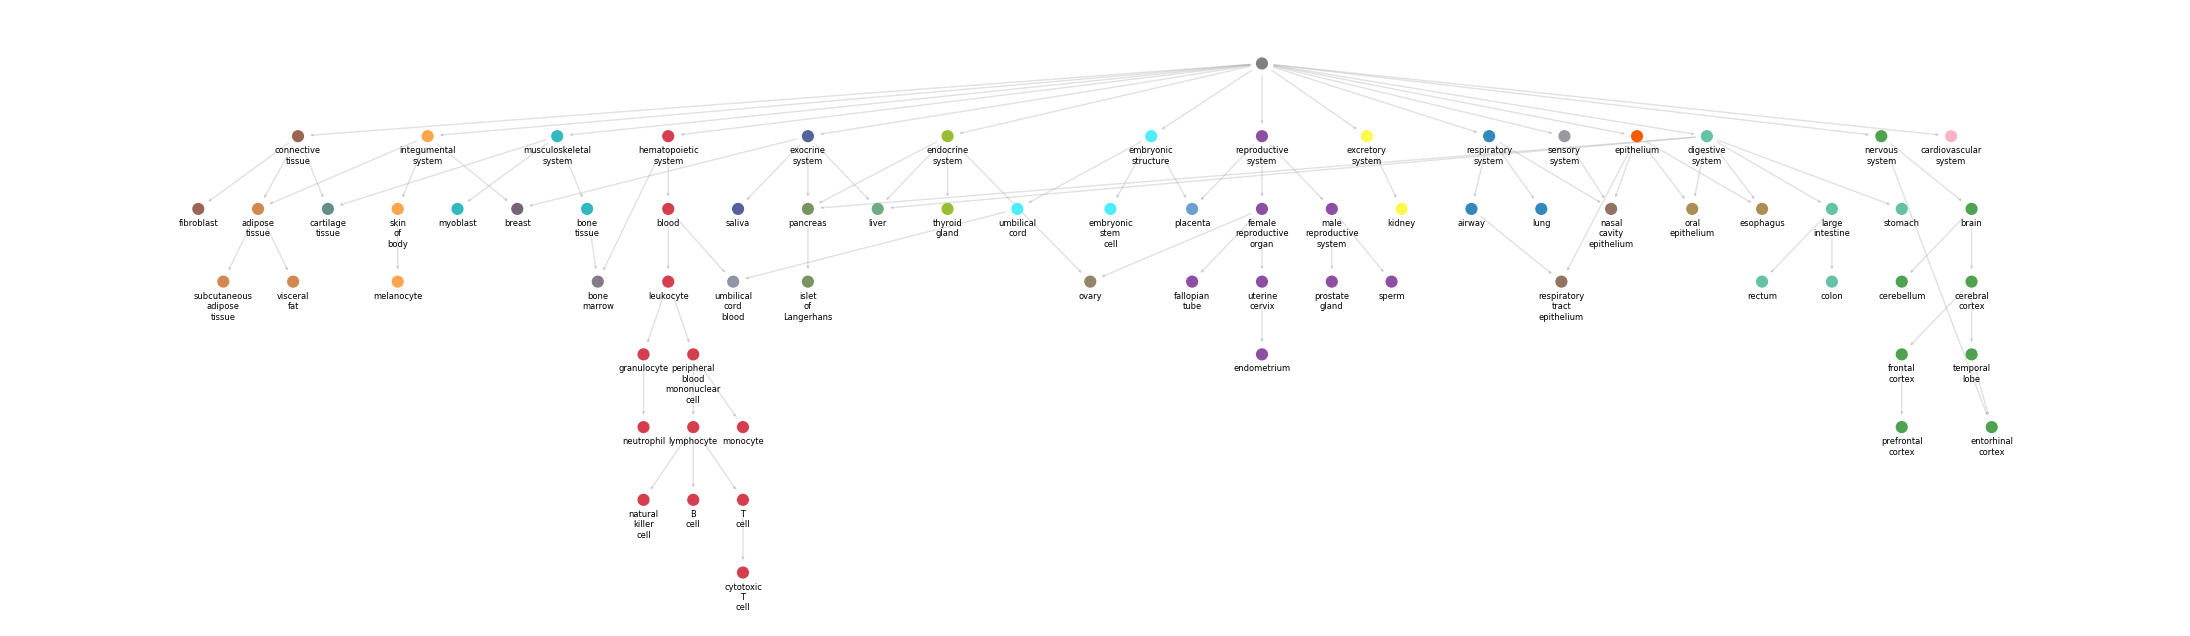

In [21]:
display_id_graph_pretty(training_ontology, id_to_name=id_to_name, node_cols=id_to_color, figsize=(28, 8), save='training_onto_with_color')

# Figure 2 - flowchart

# Figure 3

## Selection frequency cross-validation

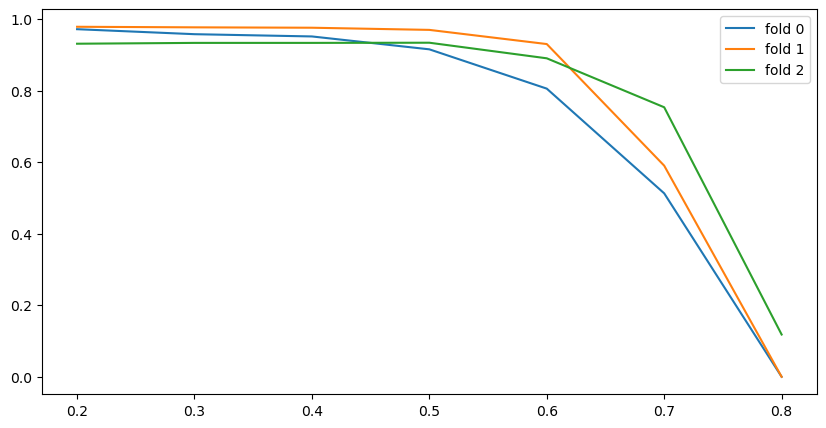

In [23]:
results = dill.load(open('./../data/GEO/minipatch/crossvalidation_results_[0.8,0.2]', 'rb'))

plt.figure(figsize = (10,5))
for fold in range(3):
    plt.plot([x for x,y in results[fold].items()], [y['custom_f1'] for x,y in results[fold].items()], label = f'fold {fold}')
plt.legend()

## Time vs feature selection method

In [24]:
diffmeth_time = pd.read_csv('./../data/GEO/time/diffmeth_times.csv', index_col=0).T.reset_index()
diffmeth_time.columns = ['n_samples', 'time (s)']
diffmeth_time['time (hrs)'] = diffmeth_time['time (s)']/(60*60)
minipatch_time = pd.read_csv('./../data/GEO/time/minipatch_times.csv', index_col=0).T.reset_index()
minipatch_time.columns = ['n_samples', 'time (s)']
minipatch_time['time (hrs)'] = minipatch_time['time (s)']/(60*60)

<AxesSubplot:xlabel='n_samples', ylabel='time (hrs)'>

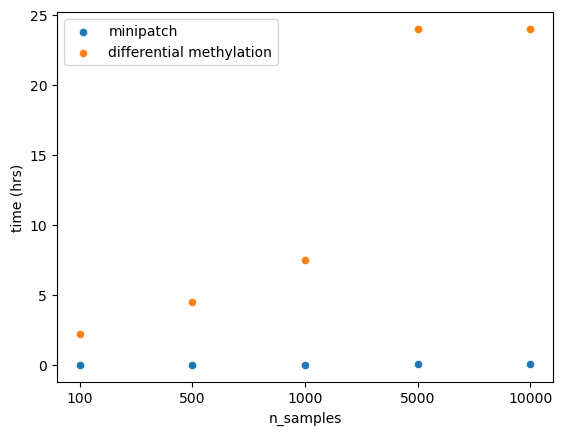

In [25]:
sns.scatterplot(data=minipatch_time, x='n_samples', y='time (hrs)', label='minipatch')
sns.scatterplot(data=diffmeth_time, x='n_samples', y='time (hrs)', label='differential methylation')

## PCA

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def scale(MVALUES):
    print(f"Scaling {MVALUES.shape}")
    return pd.DataFrame(StandardScaler().fit_transform(MVALUES), index=MVALUES.index, columns=MVALUES.columns)

def scale_pca(MVALUES, META, SCALE=True):
    scaled_Mv = scale(MVALUES) if SCALE else MVALUES
    scaled_Mv = scaled_Mv.loc[META.index]
    
    pca = PCA(n_components=2)
    pca_result =  pd.DataFrame(pca.fit_transform(scaled_Mv), index=scaled_Mv.index)
    explained_variance = pca.explained_variance_ratio_
    
    return pca_result, explained_variance

pca_result1, explained_variance1 = scale_pca(Mv, meta, SCALE=True)
pca_result2, explained_variance2 = scale_pca(Mv_minipatch, meta, SCALE=True)

Scaling (10351, 297598)
Scaling (10351, 190)


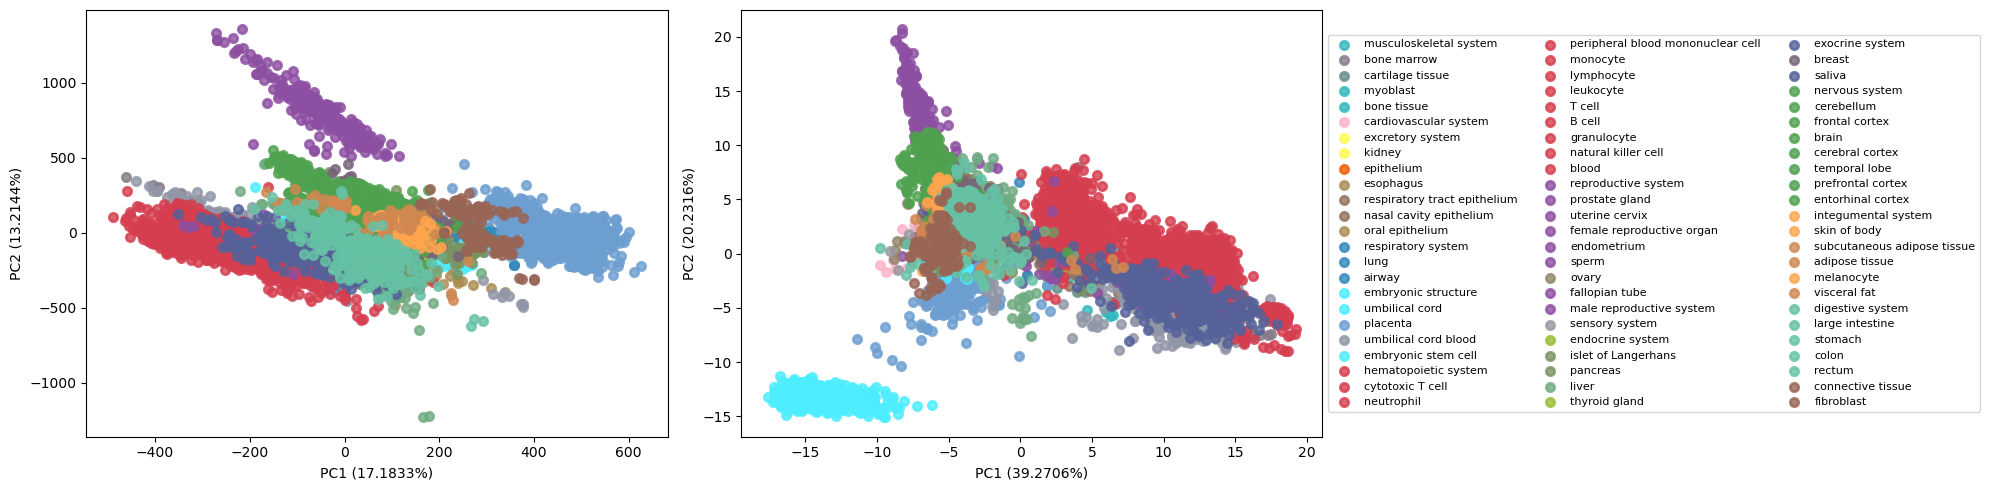

In [27]:
def plot_pca(pca_result, META, ax, explained_variance, LEGEND=False, SAVE=False, SAVENAME=''):
    for i, target_name in enumerate(descendants_set):
        if target_name == 'root': continue
        ax.scatter(pca_result.values[META['training.ID'] == target_name, 0], 
                   pca_result.values[META['training.ID'] == target_name, 1], 
                   color=id_to_color[target_name], alpha=0.8, lw=2, label=utils.id_to_name[target_name][0])
    if LEGEND: ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8, ncol=3)
    ax.set_xlabel(f"PC1 ({explained_variance[0]:.4%})")
    ax.set_ylabel(f"PC2 ({explained_variance[1]:.4%})")

    target_data = pca_result.values[META['training.ID'] == target_name]
    for x, y in target_data[:, [0, 1]]:  # Extract first and second PCA components
        if y > 10000:
            ax.annotate(f'{target_name}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
    
    if SAVE and len(SAVENAME)>0:
        plt.savefig(f'./../figures/{SAVENAME}.pdf')

# Create figure
plt.figure(figsize=(20, 5))

# Mv dataset
ax1 = plt.subplot(121)
plot_pca(pca_result1, meta, ax1, explained_variance1, SAVE=False)

# Mv_minipatch dataset
ax2 = plt.subplot(122)
plot_pca(pca_result2, meta, ax2, explained_variance2, LEGEND=True, SAVE=False)

plt.tight_layout()
plt.show()

## CpG Island distribution

In [28]:
manifest = pd.read_csv('./../annotation/HM450.hg38.manifest.gencode.v36.tsv.gz', sep='\t', header=0, index_col='probeID')
manifest = manifest.loc[Mv.columns]

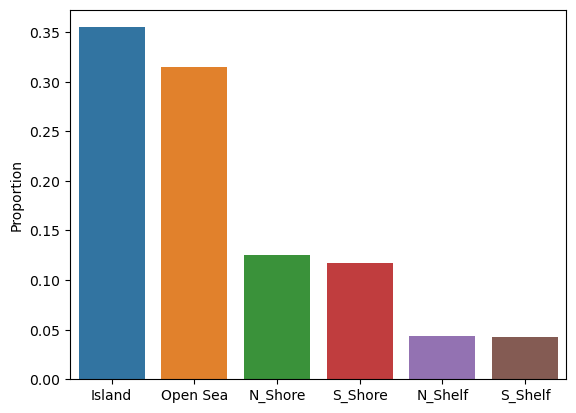

In [29]:
sns.barplot(x=manifest['CGIposition'].fillna('Open Sea').value_counts(normalize=True).index, 
            y=manifest['CGIposition'].fillna('Open Sea').value_counts(normalize=True).values)
plt.ylabel('Proportion')
plt.show()

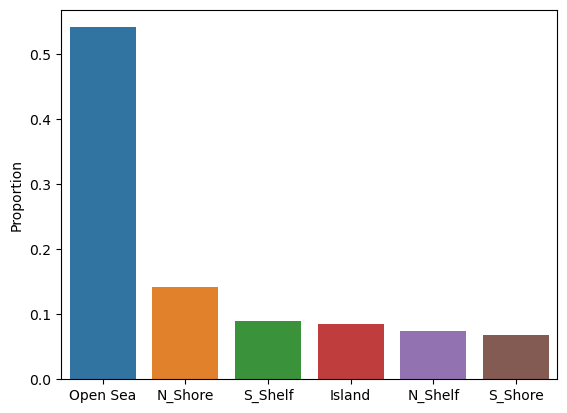

In [30]:
sns.barplot(x=manifest.loc[minipatch_probes, 'CGIposition'].fillna('Open Sea').value_counts(normalize=True).index, 
            y=manifest.loc[minipatch_probes, 'CGIposition'].fillna('Open Sea').value_counts(normalize=True).values)
plt.ylabel('Proportion')
plt.show()

# Figure 4

## Baseline precision

In [37]:
filename = "crossvalidation"
pred_location = f"./../data/GEO/minipatch/{filename}_pred"
print(f"loading pred from {pred_location}")
pred_res = pickle.load(open(pred_location, 'rb'))
print(pred_res.shape)

import re
from sklearn.metrics import accuracy_score, jaccard_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

def get_true_single(row):

    idx = re.search(r'\bGSM\d+\b', row.name).group()

    return meta.loc[idx]['training.ID']

pred_res['true_single'] = pred_res.apply(lambda row: get_true_single(row), axis=1)

loading pred from ./../data/GEO/minipatch/crossvalidation_pred
(10351, 3)


In [38]:
def single_to_dict(df, ordered_labels, method="accuracy"):
    df_dict = dict()
    
    for tissue in ordered_labels:
        if tissue in df['true'].values:
            tissue_true = df['true']==tissue
            tissue_pred = df['pred']==tissue

            if method=="accuracy":
                df_dict[tissue] = accuracy_score(tissue_true, tissue_pred)
            elif method=="precision":
                df_dict[tissue] = precision_score(tissue_true, tissue_pred)
        else:
            df_dict[tissue]=np.nan
         
    return df_dict

def multi_to_dict(pred_multi, true_multi, ordered_labels, method="accuracy"):
    true_cat = pd.DataFrame(mlb.transform(true_multi), columns=ordered_labels)
    pred_cat = pd.DataFrame(mlb.transform(pred_multi), columns=ordered_labels)

    cat_dict = dict()
    for tissue in ordered_labels:
        if method=="accuracy":
            cat_dict[tissue] = accuracy_score(true_cat[tissue], pred_cat[tissue])
        elif method=="precision":
            cat_dict[tissue] = precision_score(true_cat[tissue], pred_cat[tissue])
    return cat_dict

import matplotlib.lines as mlines

def plot_scatter(x_dict, y_dict, x_label = "multilabel acc", y_label = "differential methylation acc", save=False):
    x_dict = {x:y for x,y in x_dict.items() if pd.notna(y)}
    y_dict = {x:y for x,y in y_dict.items() if pd.notna(y)}
    
    dict_labels = list(sorted(set(x_dict.keys()).intersection(set(y_dict.keys()))))
    # colors, ordered = {t:c for t,c in zip(descendants_set, palette)}, descendants_set
    ordered=descendants_set
    labels = [label for label in ordered if label in dict_labels]
    
    plt.figure()
    fig, ax = plt.subplots(dpi=300)

    for i, label in enumerate(labels):
        x = x_dict[label]
        y = y_dict[label]
        c = [id_to_color[label]]
        ax.scatter(x, y,  c=c, label=utils.id_to_name[label][0])
        # if x<0.8 or y<0.8:
        #     ax.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=5)
    plt.xlim(round(min(list(x_dict.values())+list(y_dict.values())),1)-0.01, 1.01)
    plt.ylim(round(min(list(x_dict.values())+list(y_dict.values())),1)-0.01, 1.01)
    plt.legend(loc="center left", shadow=False, scatterpoints=1, 
               bbox_to_anchor=(1, 0.5), fontsize=12,
              ncol=2)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    line = mlines.Line2D([0, 1], [0, 1], linestyle='--', linewidth=0.5, color='grey')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    
    # Get the handles and labels of the current plot
    handles, labels = ax.get_legend_handles_labels()

    # Create the legend with two columns using plt.legend
    plt.legend(handles, labels, loc="center left", shadow=False, scatterpoints=1, bbox_to_anchor=(1, 0.5), fontsize=12, ncol=2)
    # for i, txt in enumerate(multilabel_dict.keys()):
    #     ax.annotate(txt, (x[i], y[i]))
    # plt.tight_layout()
    if save: plt.savefig(f"./../figures/scatter_{x_label}_{y_label}.pdf", bbox_inches='tight')
    plt.show()
    
def nan_no_training(perf_dict, unrepresented):
    for tissue in unrepresented:
        print(f"tissue: {perf_dict[tissue]}")
        perf_dict[tissue] = np.nan
        print(f"tissue: {perf_dict[tissue]}")
    return perf_dict

In [39]:
minipatch_prec_dict = multi_to_dict(
    pred_res['pred'], 
    pred_res['true'], 
    mlb.classes_, 
    method="precision")

In [44]:
training_folds = dill.load(open(f'./../data/GEO/preprocessed/training_folds.dill', 'rb'))
unrepresented = list()
for fold, (fold_training_mv, fold_training_meta, fold_holdout_mv, fold_holdout_meta) in training_folds.items():
    print(f"fold: {fold}")
    print(f"  training names in holdout but not in training: {[id_to_name[x][0] for x in fold_holdout_meta['training.ID'].unique() if x not in fold_training_meta['training.ID'].unique()]}")
    unrepresented.extend([x for x in fold_holdout_meta['training.ID'].unique() if x not in fold_training_meta['training.ID'].unique()])
unrepresented

fold: 0
  training names in holdout but not in training: ['umbilical cord']
fold: 1
  training names in holdout but not in training: []
fold: 2
  training names in holdout but not in training: ['frontal cortex', 'excretory system', 'sensory system']


['UBERON:0002331', 'UBERON:0001870', 'UBERON:8450002', 'UBERON:0001032']

In [45]:
with open("./../data/GEO/diffmeth/diffmeth_corr_allprobes.pkl", "rb") as f:
    diffmeth_corr = pickle.load(f)

In [46]:
diffmeth_corr_prec_dict = single_to_dict(
    diffmeth_corr, 
    mlb.classes_, 
    method="precision")
diffmeth_corr_prec_dict = nan_no_training(diffmeth_corr_prec_dict, unrepresented)

tissue: 0.0
tissue: nan
tissue: 0.0
tissue: nan
tissue: 0.0
tissue: nan
tissue: 0.0
tissue: nan


<Figure size 640x480 with 0 Axes>

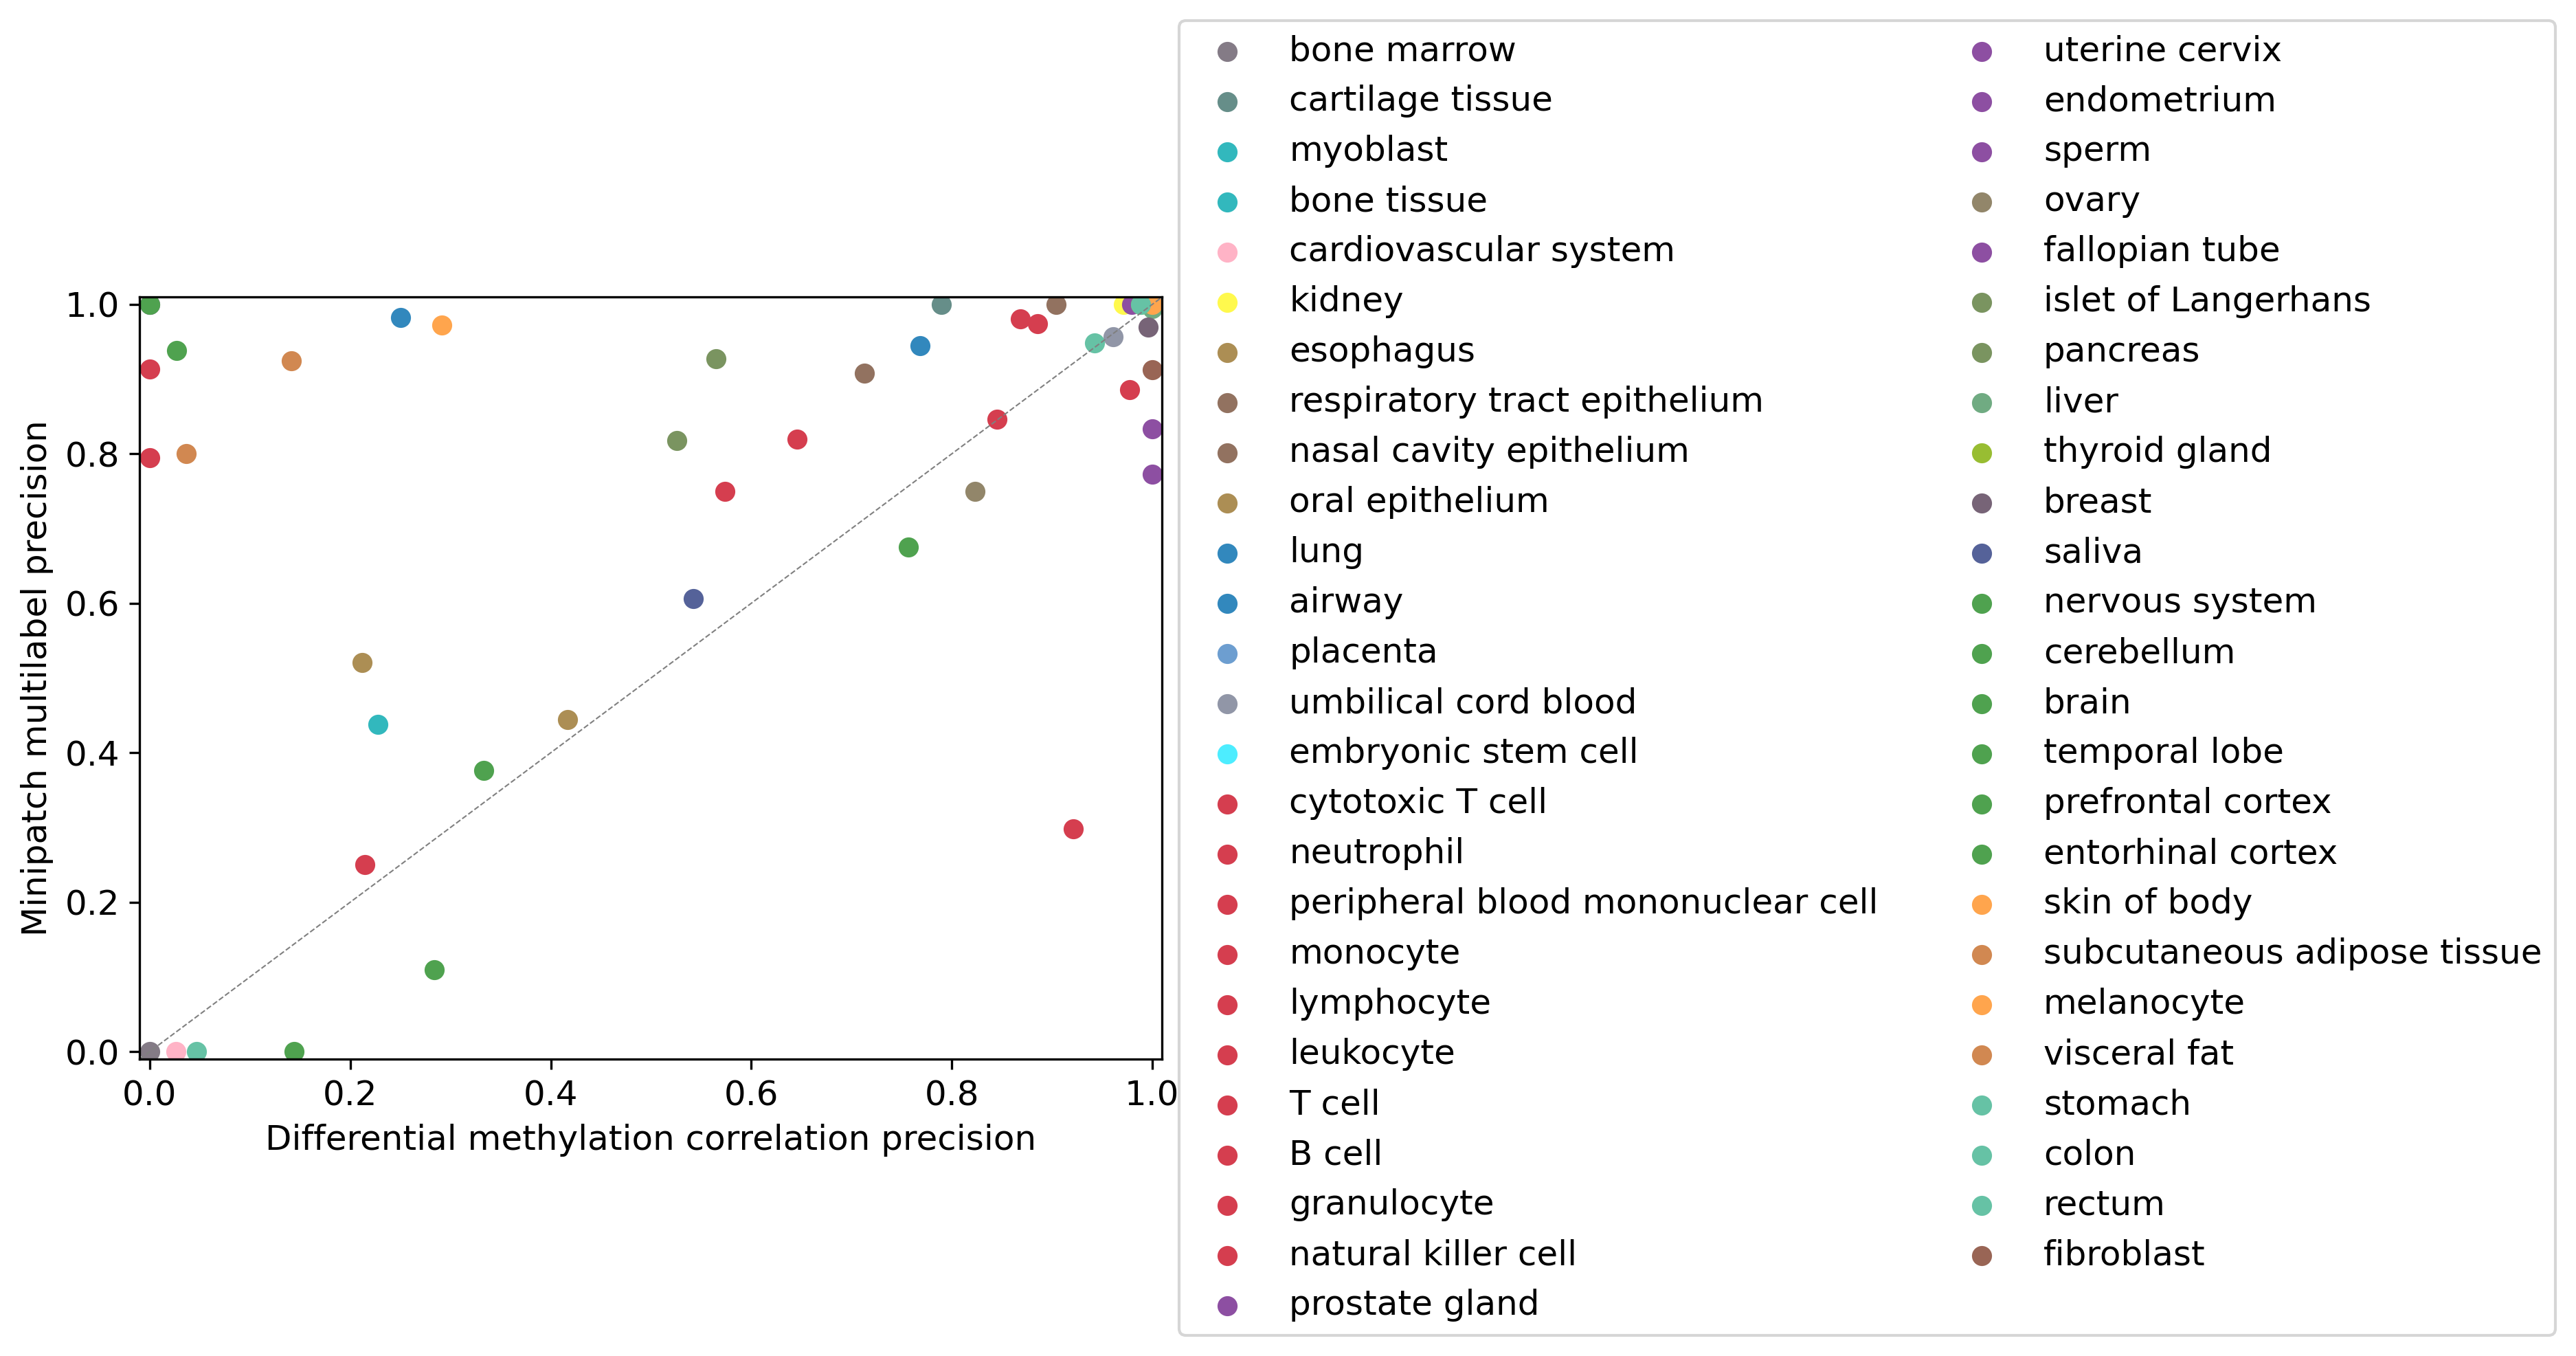

In [47]:
plot_scatter(diffmeth_corr_prec_dict, 
             minipatch_prec_dict, 
             x_label = "Differential methylation correlation precision", 
             y_label = "Minipatch multilabel precision", 
             save=True)

## Precision vs sample size

In [48]:
from collections import Counter

In [49]:
ids = [item for sublist in pred_res['true'] for item in sublist]
tissue_to_propagated_n = Counter(ids)

natural killer cell precision: 0.29850746268656714, n_samples: 130
neutrophil precision: 0.25, n_samples: 68
epithelium precision: 0.5652173913043478, n_samples: 375
esophagus precision: 0.4444444444444444, n_samples: 33
rectum precision: 0.0, n_samples: 15
temporal lobe precision: 0.3761467889908257, n_samples: 496
cerebellum precision: 0.10945273631840796, n_samples: 71
bone marrow precision: 0.0, n_samples: 74
oral epithelium precision: 0.5209580838323353, n_samples: 156
bone tissue precision: 0.4375, n_samples: 87
entorhinal cortex precision: 0.0, n_samples: 76
cardiovascular system precision: 0.0, n_samples: 10


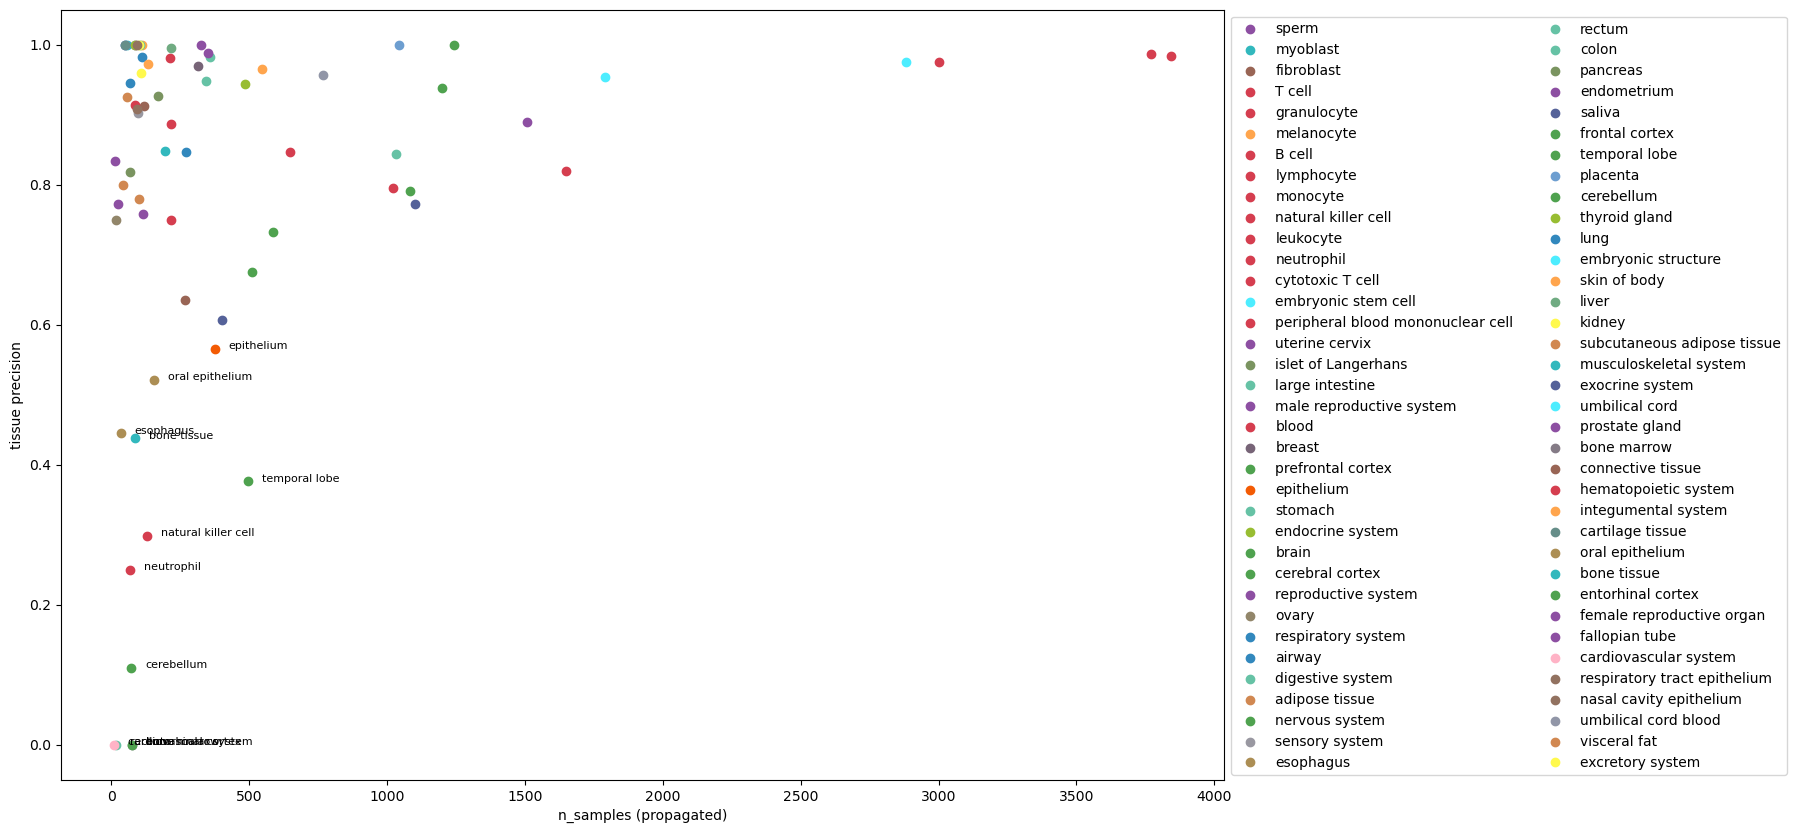

In [50]:
plt.figure(figsize=(15, 10))
perform_size = pd.DataFrame(index=['tissue name','propagated label size','precision'])

# Iterate through tissues
for i, tissue_id in enumerate(mlb.classes_):
    x_values = tissue_to_propagated_n[tissue_id]
    y_values = minipatch_prec_dict[tissue_id]
    perform_size[tissue_id] = [id_to_name[tissue_id][0], x_values, y_values]
    
    # Scatter plot
    plt.scatter(x_values, y_values, label=id_to_name[tissue_id][0], color=id_to_color[tissue_id])
    plt.ylabel('tissue precision')
    plt.xlabel('n_samples (propagated)')
    
    # Annotate points where x < 0.6
    if y_values < 0.6:
        print(f"{id_to_name[tissue_id][0]} precision: {y_values}, n_samples: {x_values}")
        plt.annotate(f"{id_to_name[tissue_id][0]}", (x_values, y_values), 
                     textcoords="offset points", xytext=(10, 0), ha='left', fontsize=8)

# Legend and show
plt.legend(bbox_to_anchor=(1, 1), ncol=2)
plt.show()

## Log2(AP/prior)

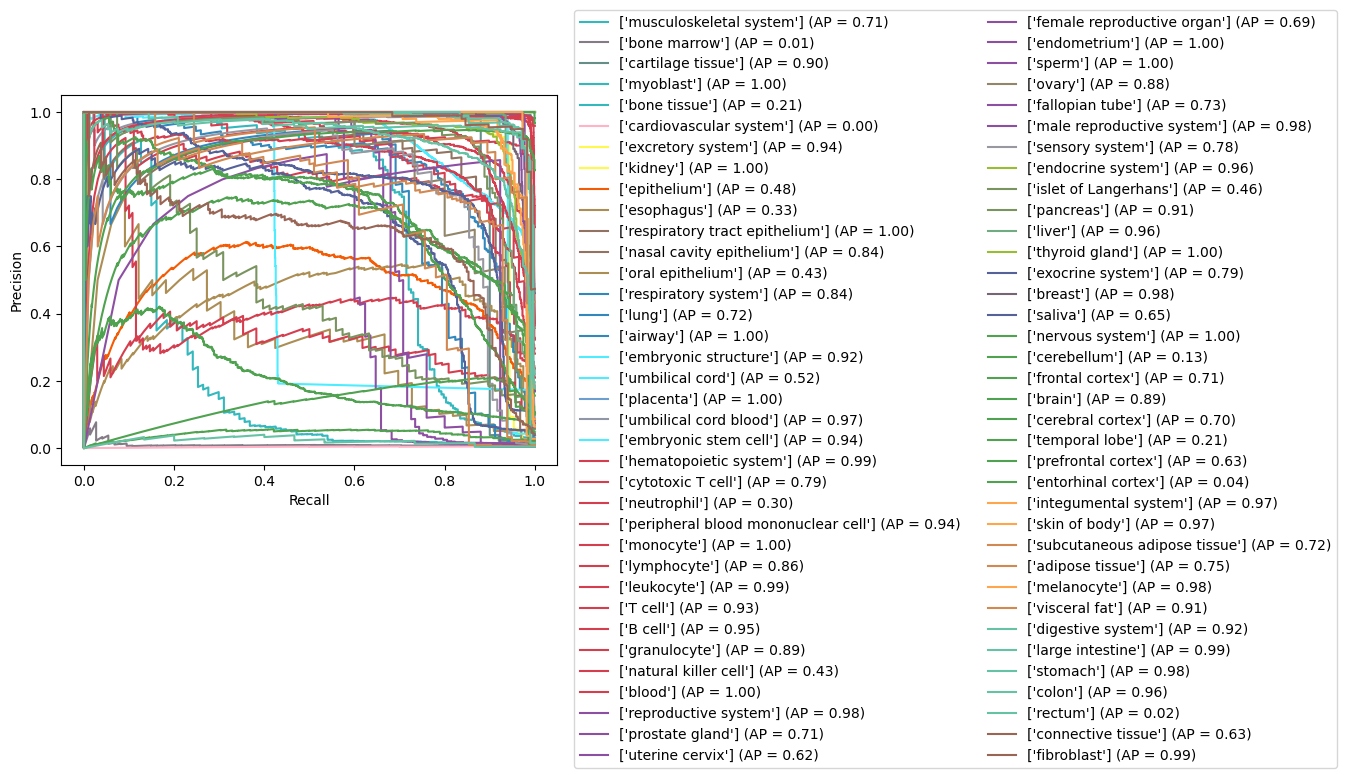

In [69]:
y_true_bin = mlb.transform(pred_res['true'])
tissue_pr = pd.DataFrame(index=['tissue','pr','rc','ap','auprc','chance','log(ap/chance)', 'log(pr/chance)'])
for i, tissue in enumerate(descendants_set):
    if tissue=='root': continue
    mlb_idx = list(mlb.classes_).index(tissue)
    y_true_tissue = y_true_bin[:, mlb_idx]
    y_score_tissue = np.vstack(pred_res['predict_proba'])[:,mlb_idx]  # Assuming 'predict_proba' is a column containing probabilities

    pr, rc, _ = precision_recall_curve(y_true_tissue, y_score_tissue)
    ave_pr = average_precision_score(y_true_tissue, y_score_tissue)
    auprc = auc(rc,pr)
    chance = np.sum(y_true_tissue) / len(y_true_tissue)
    log_ap_over_chance = np.log2(ave_pr / chance)
    log_pr_over_chance = np.log2(np.maximum(pr, 1e-10) / chance)
    tissue_pr[tissue] = [utils.id_to_name[tissue][0], pr, rc, ave_pr, auprc, chance, log_ap_over_chance, log_pr_over_chance]
    
    plt.plot(rc, pr, label=f'{str(utils.id_to_name[tissue])} (AP = {ave_pr:.2f})', color=id_to_color[tissue])
    plt.xlabel("Recall", fontsize=10)
    plt.ylabel("Precision", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # plt.scatter([], [], label=f'{tissue} (AUC = {roc_auc:.2f})', color=colors[tissue])
    plt.legend(bbox_to_anchor=(1.02, 1.25), fontsize=10, ncol=2)
plt.savefig("./../figures/prc_all.pdf", bbox_inches='tight')
# tissue_pr.to_csv('./../figures/pr.csv')

In [70]:
df_pr = pd.DataFrame(tissue_pr)
# pd.DataFrame(df_pr).to_csv('./../figures/pr.csv')
df_pr

UBERON:0002204  \
tissue                                     musculoskeletal system   
pr              [0.027430358158044343, 0.027292110874200425, 0...   
rc              [1.0, 0.9948186528497409, 0.9948186528497409, ...   
ap                                                       0.706356   
auprc                                                     0.70585   
chance                                                   0.018646   
log(ap/chance)                                           5.243494   
log(pr/chance)  [0.556942763893873, 0.5496532866950146, 0.5498...   

                                                   UBERON:0002371  \
tissue                                                bone marrow   
pr              [0.0071490677229253214, 0.007153666253955152, ...   
rc              [1.0, 0.7027027027027027, 0.7027027027027027, ...   
ap                                                       0.010609   
auprc                                                    0.009674   
chance                                                   0.007149   
log(ap/chance)                                           0.569459   
log(pr/chance)  [0.0, 0.0009276937054737694, 0.001126179643860...   

                                                   UBERON:0002418  \
tissue                                           cartilage tissue   
pr              [0.008155276463872126, 0.00799347471451876, 0....   
rc              [1.0, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98...   
ap                                                       0.898491   
auprc                                                    0.898433   
chance                                                    0.00483   
log(ap/chance)                                           7.539203   
log(pr/chance)  [0.7555758420570666, 0.7266648271281737, 0.726...   

                                                       CL:0000056  \
tissue                                                   myoblast   
pr              [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
rc              [1.0, 0.9821428571428571, 0.9642857142857143, ...   
ap                                                            1.0   
auprc                                                         1.0   
chance                                                    0.00541   
log(ap/chance)                                           7.530128   
log(pr/chance)  [7.53012760930823, 7.53012760930823, 7.5301276...   

                                                   UBERON:0002481  \
tissue                                                bone tissue   
pr              [0.008404985025601391, 0.011607019483211276, 0...   
rc              [1.0, 0.9655172413793104, 0.9655172413793104, ...   
ap                                                       0.208976   
auprc                                                    0.207162   
chance                                                   0.008405   
log(ap/chance)                                           4.635948   
log(pr/chance)  [0.0, 0.4656804020260126, 0.46587976567462486,...   

                                                   UBERON:0004535  \
tissue                                      cardiovascular system   
pr              [0.003955696202531646, 0.003561535417491096, 0...   
rc              [1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   
ap                                                       0.003699   
auprc                                                     0.00331   
chance                                                   0.000966   
log(ap/chance)                                           1.937037   
log(pr/chance)  [2.0337017831887314, 1.882269488976009, 1.8828...   

                                                   UBERON:8450002  \
tissue                                           excretory system   
pr              [0.015965383467621604, 0.015818534547082524, 0...   
rc              [1.0, 0.9906542056074766, 0.9906542056074766, ...   
ap                                         

## System sankey

In [71]:
from collections import defaultdict
import plotly.graph_objects as go

In [72]:
# Convert node RGB values into valid color strings (e.g., 'rgb(255, 0, 0)' for red)
def rgb_to_plotly_color(rgb):
    # Convert RGB tuple to RGB string (e.g., (0.8, 0.1, 0.1) -> 'rgb(204, 25, 25)')
    return f'rgb({int(rgb[0] * 255)}, {int(rgb[1] * 255)}, {int(rgb[2] * 255)})'

def hex_to_plotly_color(hex_color):
    # Remove '#' if present and convert hex to RGB
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f'rgb({rgb[0]}, {rgb[1]}, {rgb[2]})'

In [73]:
pred_res['pred_system'] = pred_res['pred'].apply(
    lambda row: [next((k for k, v in system_to_children.items() if x in v), x) for x in row]
)
pred_res['true_system'] = pred_res['true_single'].apply(
    lambda row: next((k for k, v in system_to_children.items() if row in v), row)
)

In [76]:
def create_sankey(prediction_result_df, id_to_color, save=False, system_specific=False, system_name=None):
    '''
    input pred_res in df indexed by f#.GSM###### 
    with predict_proba, pred, true, highest_proba, true_single, pred_system, true_system
    '''

    # Initialize flow_data and flow_color
    flow_data = defaultdict(int)
    flow_color = dict()
    node_color = dict()  # Dictionary to store the colors of the nodes
    
    # Iterate through the rows and set up flow_data and node_color based on systems
    for true, true_system, pred_system in zip(prediction_result_df['true_single'], 
                                              prediction_result_df['true_system'], 
                                              prediction_result_df['pred_system']):
        for p in pred_system:
            flow_data[(true, p)] += 1
            # flow_color[(true, p)] = system_to_color[true_system]  # Link color based on the true_system
            # node_color[true] = system_to_color[true_system] # Color source (true) node based on the true_system

            flow_color[(true, p)] = id_to_color[true]  # Link color based on the id
    
    # Unique values for true and predicted labels
    unique_preds = {p for pred in prediction_result_df['pred_system'] for p in pred}
    unique_trues = set(prediction_result_df['true_single'].values)
    
    # Labels for nodes
    labels = list(unique_trues) + list(unique_preds)

    # colors for nodes
    node_color = {label:id_to_color[label] for label in labels}
    
    # Prepare Sankey data
    sources, targets, values, link_colors = zip(*[
        (list(unique_trues).index(true), 
         list(unique_preds).index(pred) + len(unique_trues), 
         count, 
         flow_color[(true, pred)])
        for (true, pred), count in flow_data.items()
    ])
    
    # if RGB: 
    # Assign colors to each node based on true_system (for source nodes) and pred_system (for target nodes)
    # node_colors = [rgb_to_plotly_color(node_color.get(true, (0.8, 0.8, 0.8))) for true in unique_trues]  
    # node_colors += [rgb_to_plotly_color(node_color.get(pred, (0.8, 0.8, 0.8))) for pred in unique_preds] 

    # Make link colors semi-transparent (adjust alpha value here)
    # link_colors = [
    #     f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, 0.5)' 
    #     if isinstance(c, tuple) else 'rgba(0,0,0,0.5)' for c in link_colors
    # ]

    # if hex:
    # Assign colors to each node based on true_system (for source nodes) and pred_system (for target nodes)
    node_colors = [hex_to_plotly_color(node_color.get(true, '#CCCCCC')) for true in unique_trues]
    node_colors += [hex_to_plotly_color(node_color.get(pred, '#CCCCCC')) for pred in unique_preds] 

    # Make link colors semi-transparent (adjust alpha value here)
    link_colors = [
        f'rgba({int(c[1:3], 16)}, {int(c[3:5], 16)}, {int(c[5:7], 16)}, 0.5)' 
        if isinstance(c, str) and c.startswith('#') else 'rgba(0,0,0,0.5)' 
        for c in link_colors
    ]

    # Create Sankey plot
    fig = go.Figure(go.Sankey(
        node=dict(
            label=[id_to_name.get(label, label)[0] for label in labels],
            color=node_colors  # Use node_colors for node coloring
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors  # Use semi-transparent link_colors
        )
    ))

    if system_specific:
        # Auto-adjust figure size
        fig.update_layout(
            title=f"{system_name}: True tissue to Predicted system",
            width=max(800, len(labels) * 10),
            height=max(600, len(labels) * 15)
        )
        savename = f"./../figures/sankey/sankey_{system_name}.pdf"
    else:
        # Auto-adjust figure size
        fig.update_layout(
            title="True tissue to Predicted system",
            width=max(800, len(labels) * 10),
            height=max(600, len(labels) * 15)
        )
        savename = f"./../figures/sankey_all.pdf"

    if save:
        fig.write_image(savename)
    
    # Show figure
    fig.show()

In [77]:
create_sankey(pred_res, id_to_color, save=True, system_specific=False)